# Proyecto 4: Visión por computador usando CNNs

El objetivo de este proyecto es solucionar un problema de visión por computadora usado deep learning, particularmente las redes neuronales convolucionales (CNNs). Para este proyecto deberá plantear un problema de forma libre. Sin embargo, más adelante hay unas sugerencias de proyectos. 

## Generalidades del proyecto

- El proyecto debe crear un modelo que use CNNs y debe ponerse en producción. Es decir, que se debe exportar el modelo y posteriormente se debe cargar para pasarles las imágenes (nuevas) y que produzca una variable respuesta (etiqueta o valores numéricos).

- Si el problema es de clasificación (o regresión) se debe:
  - probar varias arquitecturas, y se debe justificar la escogencia del learning rate (u otros hiperparámetros). 
  - escoger el mejor modelo (arquitectura) y se debe intentar mejorar su desempeño (variando epocs, schedulers, etc.). 
  - con el modelo final, obtener las deep features (las características de la penúltima capa) y posteriormente realizar un diagrama de dispersión bidimensional o tridimensional usando PCA o TSNE .
  - Realizar una interfaz gráfica de usuario donde se pueda usar el modelo final en producción (sugiero usar Dash de plot.ly).
  
- Si el problema es de detección de objetos o segmentación:
   - Justificar el uso del learning rate y demás hiperparámetros.
   - Centrarse en un tipo de modelo para la detección (SSD, yolo, fastRCNN, MaskRCNN, etc.) o segmentación (Unet, Segnet, MaskRCNN, ..).
   - Comprobar los resultados con una métrica apropiada.
   - Realizar un interfaz gráfica de usuario sencilla (usando widgets por ejemplo) para poner el modelo en producción. 

- Si el problema es de revisión:
    - Escribir un estado del arte sobre el tema.
    - Explicar el método de forma concisa y clara.
    - Mostrar un ejemplo de aplicación del método (no necesariamente original, puede tomar alguno hecho, pero explicarlo y ejecutarlo)
    - Debe realizar un vídeo corto, adicional al reporte, explicando el método.
    
- El proyecto se debe realizar en grupos de 2 integrantes (no necesariamente los de siempre). Todas las opciones deben presentar un informe de máximo 5 páginas, y se debe crear un repositorio de github público donde se encuentre el código usado (notebooks, scripts, etc) y una breve descripción del proyecto. El informe debe tener: resumen, introducción, métodos, resultados y discusión, conclusiones y referencias. 
 
- El proyecto debe realizarse en python usando fast.ai y/o pytorch. 

- El reporte, el código (repositorio)  puede entregarse a más tardar el día 28 de Mayo (en la mañana).

## Sugerencias de proyectos

### Algún problema de Clasificación de imágenes

Un problema que solucione de forma efectiva una clasificación automática de diversos tipos de imágenes. En este proyecto, como se comentó antes, deben realizar una "buena" interfaz de usuario.  Un buen ejemplo de esto (no pueden usar exactamente el mismo) lo desarrollamos el año pasado en el curso de Data Science For All. En ese desarrollo usamos un clasificador CNN para clasificar diversos tipos de células normales de la sangre periférica. Desarrollamo el modelos con fastai (pero versión 1, no la versión 2 que es la que hemos usado). Usamos Dash para desarrollar la interfaz (pueden usarla como base, es el script app1.py). [Este es el repositorio](https://github.com/santialferez/Blood-Cells-Classifier/tree/master/App).

### Segmentación de leucocitos usando Unet y el ground truth creado entre todos.
Usar la arquitectura UNet (está en fastai) para realizar la segmentación de los leucocitos con base en el ground truth que crearon entre todos. Es posible también usar un dataset de segmentación abierto.

### Detección de "varios" rostros con máscarilla (y posiblemente en diferente posiciones)
La idea es usar un método de detección de objetos. fastai no implementa la detección de objetos directamente, pero la libreria [Icevision](https://github.com/airctic/icevision) implementas diversos métodos de detección que se pueden usar con fastai. [Este dataset](https://www.kaggle.com/andrewmvd/face-mask-detection) puede serle útil (ver también [este blog](https://towardsdatascience.com/face-mask-detection-using-yolov5-3734ca0d60d8) ).

### Simple detección de pose mediante regresión de varios puntos usando CNNs.
Buscar un dataset de imágenes (o frames) con distintas poses (por ejemplo ver los datasets que usan [aquí](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch) e intentar realizar una CNN con regresión múltiple (varias respuestas). 

### Investigación: One-shot learning (red siamesa), self-supervised learning (en deep learning), vision Transformers (ViT)
Realizar un trabajo más de estado del arte, con un informe que resume la técnica y muestra algún ejemplo usando fastai o pytorch (no lo tienen que desarrollar sólo usar). Si realizan esto, por favor hablar conmigo para más detalles.


---

## Solución - Proyecto 4 : Clasificación de Digitos
Juan Camilo Llanos & Santiago Martinez.

In [1]:
#importar librerias para el modelo
import torch
import torchvision

In [2]:
#definir hiperparametros, estos valores se obtuvieron al tanteo
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 10

#fijar random seed para reproducibilidad
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
#crear objetos para lectura de datos
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
#cargar datos de ejemplo
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
#definir distintas arquitecturas de red
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 15, kernel_size=5)
        self.conv2 = nn.Conv2d(15, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3)
        self.conv3 = nn.Conv2d(5, 5, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(5, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 15, kernel_size=3)
        self.conv3 = nn.Conv2d(15, 7, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(5, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [7]:
#tipo red determina cual de todas las distintas arquitecturas se
#va a usar, sus valores son 0,1,2
tipo_red=1
redes=[Net,Net2,Net3,Net4,Net5]
network = redes[tipo_red]()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [8]:
#crear listas para guardar informacion de desempenio
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
#funcion de entrenamiento de la red
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #guardar informacion del model hasta el momento
        #para tener en cuenta entrenamientos largos
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'C:\\Users\\USUARIO\\Documents\\semestre7\\vision\\results\\model'+str(tipo_red)+'.pth')
            torch.save(optimizer.state_dict(), 'C:\\Users\\USUARIO\\Documents\\semestre7\\vision\\results\\optimizer'+str(tipo_red)+'.pth')

In [10]:
#hacer test con los el entrenamiento obtenido hasta el momento
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

In [11]:
#entrenar y testear la red
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\USUARIO\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2295, Accuracy: 90/10000 (1%)


Test set: Avg. loss: 0.2300, Accuracy: 167/10000 (2%)


Test set: Avg. loss: 0.2298, Accuracy: 271/10000 (3%)


Test set: Avg. loss: 0.2303, Accuracy: 349/10000 (3%)


Test set: Avg. loss: 0.2297, Accuracy: 417/10000 (4%)


Test set: Avg. loss: 0.2301, Accuracy: 512/10000 (5%)


Test set: Avg. loss: 0.2298, Accuracy: 587/10000 (6%)


Test set: Avg. loss: 0.2297, Accuracy: 669/10000 (7%)


Test set: Avg. loss: 0.2296, Accuracy: 757/10000 (8%)


Test set: Avg. loss: 0.2298, Accuracy: 844/10000 (8%)



C:\Users\USUARIO\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294087
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.354632
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.304625
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.330151
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.292879
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.281600
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.317214
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.285801
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.288457
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.266338
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.256049
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.296335
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.280265
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.299010
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.269518
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.293846
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.254192
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.262737
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.254395
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.291587
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.184103
Train Epoch: 2 [39040/60000 (65%)]	Loss: 1.160541
Train Epoch: 2 [39680/60000 (66%)]	Loss: 1.011087
Train Epoch: 2 [40320/60000 (67%)]	Loss: 1.177644
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.990084
Train Epoch: 2 [41600/60000 (69%)]	Loss: 1.215454
Train Epoch: 2 [42240/60000 (70%)]	Loss: 1.271220
Train Epoch: 2 [42880/60000 (71%)]	Loss: 1.113542
Train Epoch: 2 [43520/60000 (72%)]	Loss: 1.150930
Train Epoch: 2 [44160/60000 (74%)]	Loss: 1.109655
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.114618
Train Epoch: 2 [45440/60000 (76%)]	Loss: 1.087300
Train Epoch: 2 [46080/60000 (77%)]	Loss: 1.019809
Train Epoch: 2 [46720/60000 (78%)]	Loss: 1.111795
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.932646
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.090327
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.044123
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.212468
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.393126
Train Epoch: 2 [50560/60000 (84%)]	Loss: 1.014235


In [12]:
#esta linea coje una datos y realiza la prediccion
with torch.no_grad():
    output = network(example_data)

C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [18]:
#este bloque y el siguiente es para visualizar
#la prediccion contra el valor real
import numpy as np

np.argmax(output[123].numpy())

7

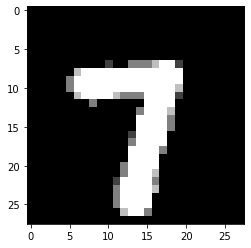

In [17]:
import matplotlib.pyplot as plt

plt.imshow(example_data[123][0],cmap='gray')

In [19]:
'C:\\Users\\USUARIO\\Documents\\semestre7\\vision\\results\\model'+str(tipo_red)+'.pth'

'C:\\Users\\USUARIO\\Documents\\semestre7\\vision\\results\\model1.pth'

In [20]:
#ensayo sobre cargar un modelo previamente entrenado
model=redes[tipo_red]()
model.load_state_dict(torch.load('C:\\Users\\USUARIO\\Documents\\semestre7\\vision\\results\\model'+str(tipo_red)+'.pth'))
salid=model(example_data)

C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
salid

tensor([[-4.0795e+00, -4.7023e+00, -5.0428e+00,  ..., -1.3847e+00,
         -5.2096e+00, -1.3634e+00],
        [-1.2603e+01, -1.3562e+01, -1.6126e+01,  ..., -7.2464e+00,
         -8.7493e+00, -1.2588e+00],
        [-3.0356e+00, -4.3548e+00, -2.6273e+00,  ..., -1.4770e+00,
         -2.1733e+00, -2.4154e+00],
        ...,
        [-1.2295e+01, -1.2701e+01, -7.6031e+00,  ..., -9.0304e+00,
         -9.0797e+00, -2.4469e+00],
        [-2.0080e+01, -5.2600e+00, -1.4203e+01,  ..., -6.3113e+00,
         -4.5811e+00, -8.4201e-01],
        [-1.4088e+01, -2.0881e+01, -2.2738e+01,  ..., -5.7776e-04,
         -1.7191e+01, -7.4586e+00]], grad_fn=<LogSoftmaxBackward>)

In [22]:
#obenter pesos de la red
parametros=[param for param in model.parameters()]

In [23]:
#seleccionar penultima capa y convertir en numpy para realizar pca
import numpy as np

deep_features=[parametros[-2][i].detach().numpy() for i in range(10)]
deep_features=np.array(deep_features)

In [24]:
#sacar matriz de covarianza junto con valores y vectores propios
S=np.cov(deep_features.T)
w, v = np.linalg.eig(S)
indi=np.argsort(np.abs(w))

In [25]:
#crear matriz de proyeccion sobre ejes principales
v1=v[:,indi[-1]]
v2=v[:,indi[-2]]

proyec=np.array([v1,v2])

In [26]:
#proyectar datos sobre ejes principales
pca_proyec=proyec@(deep_features.T)

C:\Users\USUARIO\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


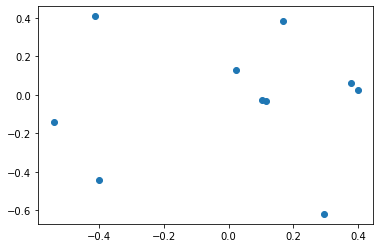

In [27]:
#graficar proyeccion de datos sobre ejes principales
pca_proyec

plt.scatter(pca_proyec[0,:],pca_proyec[1,:])

In [ ]:
#estas redes tienen learning rate de 0.001 3 epochs
#red 0 tiene 9832
#red 1 tiene 9836
#red 2 tiene 9816
#estas redes se entrenaron con 10 epocas
#red 4 tiene 6505 learning rate 0.01 con mas pequeño hace overfitting
#red 5 es la peor con 3958 para learning rate de 0.001 

C:\Users\USUARIO\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


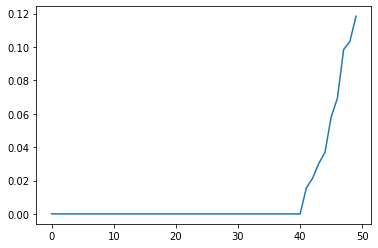

In [28]:
plt.plot(np.sort(w))

### Testeo de producción

Decidimos hacer una pequeña ilustración de como decidimos dejar el proyecto para añadirlo a algún servicio pues nos dimos cuenta que no se acopla muy bien con dash ya que las imágenes se almacenan en base 64 entre otras dificultades.

In [6]:
from skimage.io import imread
import matplotlib.pyplot as plt
from utils import prediction_function
# Esta funcion rescala a tamaño 28x28 una imagen de un digito, la vuelve binaria y le ajusta el color para que 
# quede igual a los datos entrenados es decir, digito en blanco y fondo en negro.


In [7]:
img1 = imread("test/1.jpg")
img5 = imread("test/5.jpg")
img6 = imread("test/6.jpg")
img9 = imread("test/9.jpg")

print(prediction_function(img1))
print(prediction_function(img5))
print(prediction_function(img6))
print(prediction_function(img9))

/media/juanc/My Passport2/BACKUP_WINDOWS/Estudios/Universidad/8vo_semestre/Computer Vision/Proyectos/Proyecto 4/utils.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


8
2
6
3


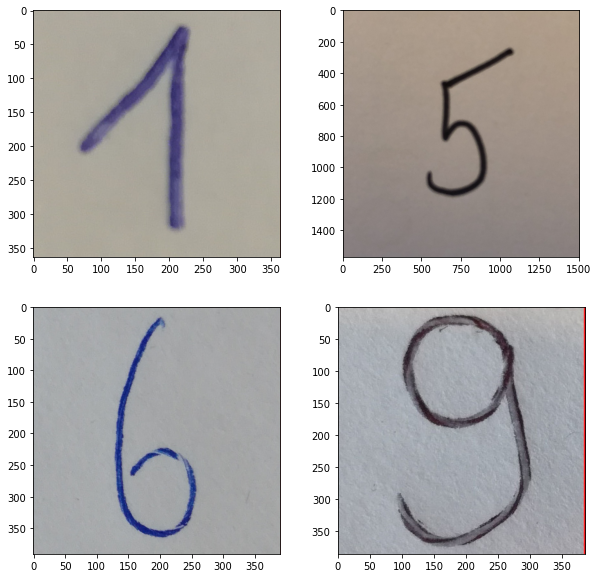

In [8]:
f, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(img1)
ax[0,1].imshow(img5)
ax[1,0].imshow(img6)
ax[1,1].imshow(img9)
